In [2]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [4]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 1., 1000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.000289411670; False Transient Error: 0.000001161700; Iterations: 584; CG Error: 0.000000000098
Episode 957: PDE Error: 0.002042111889; False Transient Error: 0.000000995661; Iterations: 697; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.016472298678; False Transient Error: 0.000002347391; Iterations: 778; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.006265141508; False Transient Error: 0.000001631688; Iterations: 781; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.032310887478; False Transient Error: 0.000002476669; Iterations: 758; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.038141265845; False Transient Error: 0.000002397040; Iterations: 747; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.028391879423; False Transient Error: 0.000002499763; Iterations: 775; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.024443394645; False Transient Error: 0.000002491579; Iterations: 783; CG Error: 0.000000000099
Episode 1000: PDE Error: 

In [6]:
np.save("v_list_{}", ϕ_list)
np.save("e_list_2", ems_list)

In [6]:
ϕ_list = np.load("v_list_1.npy")
ems_list = np.load("e_list_1.npy")

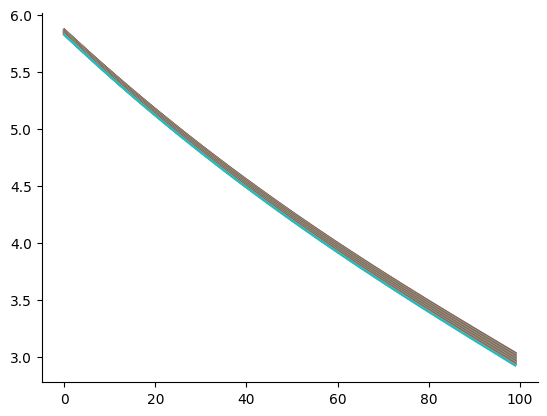

In [7]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

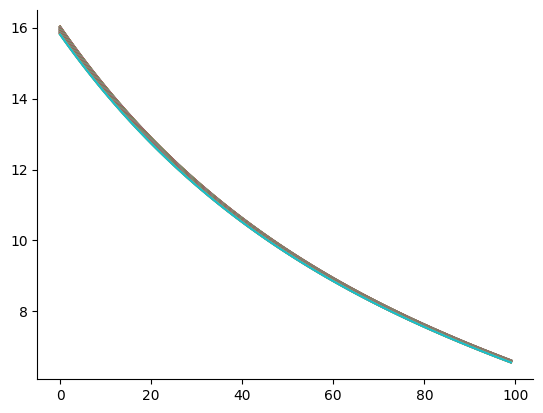

In [8]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [12]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 20_000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.589236468609	 rhs error: 0.582902771064
Episode: 2	 lhs error: 0.584449252462	 rhs error: 0.580135699841
Episode: 3	 lhs error: 0.574148594202	 rhs error: 0.568710989164
Episode: 4	 lhs error: 0.556254487154	 rhs error: 0.552436619301
Episode: 5	 lhs error: 0.537166865948	 rhs error: 0.533074006840
Episode: 6	 lhs error: 0.515211282521	 rhs error: 0.511574480935
Episode: 7	 lhs error: 0.491248483019	 rhs error: 0.488713649548
Episode: 8	 lhs error: 0.467113103593	 rhs error: 0.464999002060
Episode: 9	 lhs error: 0.443325699654	 rhs error: 0.440774324422
Episode: 10	 lhs error: 0.418111024886	 rhs error: 0.416452348451
Episode: 11	 lhs error: 0.394250684809	 rhs error: 0.392216323610
Episode: 12	 lhs error: 0.369804474758	 rhs error: 0.368378119451
Episode: 13	 lhs error: 0.346683912966	 rhs error: 0.344984442920
Episode: 14	 lhs error: 0.323791641984	 rhs error: 0.322316202297
Episode: 15	 lhs error: 0.301774526448	 rhs error: 0.300444157525
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.042371340599	 rhs error: 0.121884878963
Episode: 126	 lhs error: 0.042486829518	 rhs error: 0.121861284256
Episode: 127	 lhs error: 0.042178246010	 rhs error: 0.121823094196
Episode: 128	 lhs error: 0.041714040948	 rhs error: 0.121778214026
Episode: 129	 lhs error: 0.041999763047	 rhs error: 0.121720359717
Episode: 130	 lhs error: 0.041644076380	 rhs error: 0.121674437075
Episode: 131	 lhs error: 0.041494268394	 rhs error: 0.121609107358
Episode: 132	 lhs error: 0.041270843587	 rhs error: 0.121537693052
Episode: 133	 lhs error: 0.041252007307	 rhs error: 0.121455134795
Episode: 134	 lhs error: 0.040999687856	 rhs error: 0.121387803381
Episode: 135	 lhs error: 0.040716708636	 rhs error: 0.121298954251
Episode: 136	 lhs error: 0.040605023470	 rhs error: 0.121196505182
Episode: 137	 lhs error: 0.040302469930	 rhs error: 0.121093768758
Episode: 138	 lhs error: 0.040596710307	 rhs error: 0.120992081571
Episode: 139	 lhs error: 0.040413268745	 rhs error: 0.12089314

Episode: 249	 lhs error: 0.029255584119	 rhs error: 0.120798169916
Episode: 250	 lhs error: 0.029090166052	 rhs error: 0.120551667601
Episode: 251	 lhs error: 0.029025909338	 rhs error: 0.120262094704
Episode: 252	 lhs error: 0.028955703739	 rhs error: 0.119977860895
Episode: 253	 lhs error: 0.028880595884	 rhs error: 0.119690638244
Episode: 254	 lhs error: 0.028803338908	 rhs error: 0.119399377903
Episode: 255	 lhs error: 0.028725042692	 rhs error: 0.119103857941
Episode: 256	 lhs error: 0.028646031670	 rhs error: 0.118804034761
Episode: 257	 lhs error: 0.028565643682	 rhs error: 0.118499910754
Episode: 258	 lhs error: 0.028480425129	 rhs error: 0.118191503271
Episode: 259	 lhs error: 0.028387555218	 rhs error: 0.117878821427
Episode: 260	 lhs error: 0.028295803545	 rhs error: 0.117561688779
Episode: 261	 lhs error: 0.028207220196	 rhs error: 0.117239683710
Episode: 262	 lhs error: 0.028118889836	 rhs error: 0.116913045416
Episode: 263	 lhs error: 0.027832820039	 rhs error: 0.11658245

Episode: 373	 lhs error: 0.022120858188	 rhs error: 0.078870811168
Episode: 374	 lhs error: 0.022084052730	 rhs error: 0.078583480997
Episode: 375	 lhs error: 0.022050666087	 rhs error: 0.078293544257
Episode: 376	 lhs error: 0.022018895873	 rhs error: 0.078001452981
Episode: 377	 lhs error: 0.021986899573	 rhs error: 0.077707357134
Episode: 378	 lhs error: 0.021953798772	 rhs error: 0.077411260531
Episode: 379	 lhs error: 0.021921287343	 rhs error: 0.077113226821
Episode: 380	 lhs error: 0.021890083115	 rhs error: 0.076813473431
Episode: 381	 lhs error: 0.021860036889	 rhs error: 0.076512484241
Episode: 382	 lhs error: 0.021828813716	 rhs error: 0.076210552731
Episode: 383	 lhs error: 0.021794712976	 rhs error: 0.075907162038
Episode: 384	 lhs error: 0.021758394581	 rhs error: 0.075601234314
Episode: 385	 lhs error: 0.021718659247	 rhs error: 0.075292394500
Episode: 386	 lhs error: 0.021676646321	 rhs error: 0.074981007277
Episode: 387	 lhs error: 0.021634859498	 rhs error: 0.07466784

Episode: 497	 lhs error: 0.017615982926	 rhs error: 0.042348649017
Episode: 498	 lhs error: 0.017597676954	 rhs error: 0.042124603793
Episode: 499	 lhs error: 0.017579144263	 rhs error: 0.041899885254
Episode: 500	 lhs error: 0.017560260884	 rhs error: 0.041674534611
Episode: 501	 lhs error: 0.017541037221	 rhs error: 0.041448580548
Episode: 502	 lhs error: 0.017521574875	 rhs error: 0.041222049691
Episode: 503	 lhs error: 0.017501795434	 rhs error: 0.040994976844
Episode: 504	 lhs error: 0.017481670932	 rhs error: 0.040767388355
Episode: 505	 lhs error: 0.017461258376	 rhs error: 0.040539314738
Episode: 506	 lhs error: 0.017440616896	 rhs error: 0.040310792137
Episode: 507	 lhs error: 0.017419607271	 rhs error: 0.040081854693
Episode: 508	 lhs error: 0.017398295619	 rhs error: 0.039852526192
Episode: 509	 lhs error: 0.017376691795	 rhs error: 0.039622837126
Episode: 510	 lhs error: 0.017354771529	 rhs error: 0.039392814259
Episode: 511	 lhs error: 0.017332541656	 rhs error: 0.03916249

Episode: 621	 lhs error: 0.014494445155	 rhs error: 0.029189074253
Episode: 622	 lhs error: 0.014477609662	 rhs error: 0.029168829712
Episode: 623	 lhs error: 0.014460587626	 rhs error: 0.029148923187
Episode: 624	 lhs error: 0.014443377724	 rhs error: 0.029129352208
Episode: 625	 lhs error: 0.014425977483	 rhs error: 0.029110114133
Episode: 626	 lhs error: 0.014408365396	 rhs error: 0.029091206304
Episode: 627	 lhs error: 0.014390538685	 rhs error: 0.029072623708
Episode: 628	 lhs error: 0.014372514825	 rhs error: 0.029054360954
Episode: 629	 lhs error: 0.014354302955	 rhs error: 0.029036414791
Episode: 630	 lhs error: 0.014335893218	 rhs error: 0.029018782799
Episode: 631	 lhs error: 0.014317260678	 rhs error: 0.029001461524
Episode: 632	 lhs error: 0.014298411024	 rhs error: 0.028984445139
Episode: 633	 lhs error: 0.014279379015	 rhs error: 0.028967728430
Episode: 634	 lhs error: 0.014260139940	 rhs error: 0.028951309925
Episode: 635	 lhs error: 0.014240663218	 rhs error: 0.02893518

Episode: 745	 lhs error: 0.012157703310	 rhs error: 0.028206153649
Episode: 746	 lhs error: 0.012140054010	 rhs error: 0.028203896864
Episode: 747	 lhs error: 0.012122220268	 rhs error: 0.028201650419
Episode: 748	 lhs error: 0.012104194401	 rhs error: 0.028199413332
Episode: 749	 lhs error: 0.012085989694	 rhs error: 0.028197183720
Episode: 750	 lhs error: 0.012067601518	 rhs error: 0.028194961295
Episode: 751	 lhs error: 0.012049027092	 rhs error: 0.028192745199
Episode: 752	 lhs error: 0.012030271803	 rhs error: 0.028190534312
Episode: 753	 lhs error: 0.012011332330	 rhs error: 0.028188328270
Episode: 754	 lhs error: 0.011992214360	 rhs error: 0.028186126172
Episode: 755	 lhs error: 0.011972913382	 rhs error: 0.028183927858
Episode: 756	 lhs error: 0.011953425774	 rhs error: 0.028181732709
Episode: 757	 lhs error: 0.011933752918	 rhs error: 0.028179539716
Episode: 758	 lhs error: 0.011913909828	 rhs error: 0.028177348148
Episode: 759	 lhs error: 0.011893887400	 rhs error: 0.02817515

Episode: 869	 lhs error: 0.010240342443	 rhs error: 0.028019988989
Episode: 870	 lhs error: 0.010228455035	 rhs error: 0.028019737549
Episode: 871	 lhs error: 0.010216439824	 rhs error: 0.028019503552
Episode: 872	 lhs error: 0.010204297992	 rhs error: 0.028019286511
Episode: 873	 lhs error: 0.010192030009	 rhs error: 0.028019086249
Episode: 874	 lhs error: 0.010179631469	 rhs error: 0.028018902657
Episode: 875	 lhs error: 0.010167108724	 rhs error: 0.028018734941
Episode: 876	 lhs error: 0.010154459363	 rhs error: 0.028018583367
Episode: 877	 lhs error: 0.010141680053	 rhs error: 0.028018447839
Episode: 878	 lhs error: 0.010128771143	 rhs error: 0.028018327695
Episode: 879	 lhs error: 0.010115733642	 rhs error: 0.028018222411
Episode: 880	 lhs error: 0.010102569324	 rhs error: 0.028018131614
Episode: 881	 lhs error: 0.010089274494	 rhs error: 0.028018055284
Episode: 882	 lhs error: 0.010075851182	 rhs error: 0.028017992763
Episode: 883	 lhs error: 0.010062296834	 rhs error: 0.02801794

Episode: 993	 lhs error: 0.008722369374	 rhs error: 0.028025757754
Episode: 994	 lhs error: 0.008712275540	 rhs error: 0.028025614350
Episode: 995	 lhs error: 0.008702080888	 rhs error: 0.028025468136
Episode: 996	 lhs error: 0.008691786227	 rhs error: 0.028025319122
Episode: 997	 lhs error: 0.008681392566	 rhs error: 0.028025167607
Episode: 998	 lhs error: 0.008670896871	 rhs error: 0.028025014137
Episode: 999	 lhs error: 0.008660301358	 rhs error: 0.028024858457
Episode: 1000	 lhs error: 0.008649604355	 rhs error: 0.028024700905
Episode: 1001	 lhs error: 0.008638808112	 rhs error: 0.028024541496
Episode: 1002	 lhs error: 0.008627910184	 rhs error: 0.028024380752
Episode: 1003	 lhs error: 0.008616912006	 rhs error: 0.028024218636
Episode: 1004	 lhs error: 0.008605812163	 rhs error: 0.028024055479
Episode: 1005	 lhs error: 0.008594611776	 rhs error: 0.028023891215
Episode: 1006	 lhs error: 0.008583311763	 rhs error: 0.028023726118
Episode: 1007	 lhs error: 0.008571909782	 rhs error: 0.

Episode: 1117	 lhs error: 0.007475506778	 rhs error: 0.028015482574
Episode: 1118	 lhs error: 0.007465758206	 rhs error: 0.028015417066
Episode: 1119	 lhs error: 0.007455926029	 rhs error: 0.028015347372
Episode: 1120	 lhs error: 0.007446009870	 rhs error: 0.028015273539
Episode: 1121	 lhs error: 0.007436008707	 rhs error: 0.028015195364
Episode: 1122	 lhs error: 0.007425924716	 rhs error: 0.028015112292
Episode: 1123	 lhs error: 0.007415755941	 rhs error: 0.028015024843
Episode: 1124	 lhs error: 0.007405502960	 rhs error: 0.028014932594
Episode: 1125	 lhs error: 0.007395166036	 rhs error: 0.028014835424
Episode: 1126	 lhs error: 0.007384744923	 rhs error: 0.028014733358
Episode: 1127	 lhs error: 0.007374239359	 rhs error: 0.028014626320
Episode: 1128	 lhs error: 0.007363649547	 rhs error: 0.028014514150
Episode: 1129	 lhs error: 0.007355258608	 rhs error: 0.028014396822
Episode: 1130	 lhs error: 0.007347718850	 rhs error: 0.028014274518
Episode: 1131	 lhs error: 0.007340101836	 rhs er

Episode: 1241	 lhs error: 0.006436615500	 rhs error: 0.027995341441
Episode: 1242	 lhs error: 0.006429011846	 rhs error: 0.027995369559
Episode: 1243	 lhs error: 0.006421341978	 rhs error: 0.027995401259
Episode: 1244	 lhs error: 0.006413605749	 rhs error: 0.027995436425
Episode: 1245	 lhs error: 0.006405803181	 rhs error: 0.027995475055
Episode: 1246	 lhs error: 0.006397934220	 rhs error: 0.027995516749
Episode: 1247	 lhs error: 0.006389998729	 rhs error: 0.027995561534
Episode: 1248	 lhs error: 0.006381996736	 rhs error: 0.027995609338
Episode: 1249	 lhs error: 0.006373928215	 rhs error: 0.027995659980
Episode: 1250	 lhs error: 0.006365793105	 rhs error: 0.027995713143
Episode: 1251	 lhs error: 0.006357591318	 rhs error: 0.027995768750
Episode: 1252	 lhs error: 0.006349322851	 rhs error: 0.027995826656
Episode: 1253	 lhs error: 0.006340987693	 rhs error: 0.027995886710
Episode: 1254	 lhs error: 0.006332585799	 rhs error: 0.027995948603
Episode: 1255	 lhs error: 0.006324117126	 rhs er

Episode: 1365	 lhs error: 0.005562911698	 rhs error: 0.027983344753
Episode: 1366	 lhs error: 0.005556057740	 rhs error: 0.027983130886
Episode: 1367	 lhs error: 0.005549148211	 rhs error: 0.027982921563
Episode: 1368	 lhs error: 0.005542182052	 rhs error: 0.027982716545
Episode: 1369	 lhs error: 0.005535159309	 rhs error: 0.027982516139
Episode: 1370	 lhs error: 0.005528079974	 rhs error: 0.027982320525
Episode: 1371	 lhs error: 0.005520944159	 rhs error: 0.027982129856
Episode: 1372	 lhs error: 0.005513752137	 rhs error: 0.027981944212
Episode: 1373	 lhs error: 0.005506741287	 rhs error: 0.027981763617
Episode: 1374	 lhs error: 0.005501145485	 rhs error: 0.027981588119
Episode: 1375	 lhs error: 0.005495496667	 rhs error: 0.027981417665
Episode: 1376	 lhs error: 0.005489794768	 rhs error: 0.027981252381
Episode: 1377	 lhs error: 0.005484039859	 rhs error: 0.027981092380
Episode: 1378	 lhs error: 0.005478231445	 rhs error: 0.027980937774
Episode: 1379	 lhs error: 0.005472370688	 rhs er

Episode: 1489	 lhs error: 0.004820433551	 rhs error: 0.027987957078
Episode: 1490	 lhs error: 0.004814985030	 rhs error: 0.027987963784
Episode: 1491	 lhs error: 0.004809493763	 rhs error: 0.027987962888
Episode: 1492	 lhs error: 0.004803958417	 rhs error: 0.027987954215
Episode: 1493	 lhs error: 0.004798380367	 rhs error: 0.027987937949
Episode: 1494	 lhs error: 0.004792758927	 rhs error: 0.027987913871
Episode: 1495	 lhs error: 0.004787093768	 rhs error: 0.027987881943
Episode: 1496	 lhs error: 0.004781385300	 rhs error: 0.027987842230
Episode: 1497	 lhs error: 0.004775632722	 rhs error: 0.027987794671
Episode: 1498	 lhs error: 0.004769837223	 rhs error: 0.027987739412
Episode: 1499	 lhs error: 0.004763998202	 rhs error: 0.027987676134
Episode: 1500	 lhs error: 0.004758114944	 rhs error: 0.027987604884
Episode: 1501	 lhs error: 0.004752187555	 rhs error: 0.027987525773
Episode: 1502	 lhs error: 0.004746216328	 rhs error: 0.027987438885
Episode: 1503	 lhs error: 0.004741262974	 rhs er

Episode: 1613	 lhs error: 0.004188447518	 rhs error: 0.027970203397
Episode: 1614	 lhs error: 0.004183345554	 rhs error: 0.027970273701
Episode: 1615	 lhs error: 0.004178204227	 rhs error: 0.027970349120
Episode: 1616	 lhs error: 0.004173023362	 rhs error: 0.027970429680
Episode: 1617	 lhs error: 0.004167805141	 rhs error: 0.027970515472
Episode: 1618	 lhs error: 0.004163278354	 rhs error: 0.027970606086
Episode: 1619	 lhs error: 0.004158919763	 rhs error: 0.027970701622
Episode: 1620	 lhs error: 0.004154524563	 rhs error: 0.027970801975
Episode: 1621	 lhs error: 0.004150092560	 rhs error: 0.027970906996
Episode: 1622	 lhs error: 0.004145623316	 rhs error: 0.027971016626
Episode: 1623	 lhs error: 0.004141117110	 rhs error: 0.027971130755
Episode: 1624	 lhs error: 0.004136574551	 rhs error: 0.027971249311
Episode: 1625	 lhs error: 0.004131994431	 rhs error: 0.027971372108
Episode: 1626	 lhs error: 0.004127377407	 rhs error: 0.027971499190
Episode: 1627	 lhs error: 0.004122723871	 rhs er

Episode: 1737	 lhs error: 0.003545023272	 rhs error: 0.027991736568
Episode: 1738	 lhs error: 0.003538143987	 rhs error: 0.027991893230
Episode: 1739	 lhs error: 0.003531228761	 rhs error: 0.027992049576
Episode: 1740	 lhs error: 0.003524280701	 rhs error: 0.027992205815
Episode: 1741	 lhs error: 0.003517295889	 rhs error: 0.027992361630
Episode: 1742	 lhs error: 0.003510275660	 rhs error: 0.027992517308
Episode: 1743	 lhs error: 0.003503221200	 rhs error: 0.027992672857
Episode: 1744	 lhs error: 0.003496133275	 rhs error: 0.027992828217
Episode: 1745	 lhs error: 0.003489009818	 rhs error: 0.027992983228
Episode: 1746	 lhs error: 0.003481851788	 rhs error: 0.027993138049
Episode: 1747	 lhs error: 0.003474659441	 rhs error: 0.027993292727
Episode: 1748	 lhs error: 0.003467433091	 rhs error: 0.027993447262
Episode: 1749	 lhs error: 0.003460172742	 rhs error: 0.027993601567
Episode: 1750	 lhs error: 0.003452878937	 rhs error: 0.027993755621
Episode: 1751	 lhs error: 0.003445550240	 rhs er

Episode: 1861	 lhs error: 0.002500090699	 rhs error: 0.027964493117
Episode: 1862	 lhs error: 0.002490922433	 rhs error: 0.027963127477
Episode: 1863	 lhs error: 0.002481748845	 rhs error: 0.027961738326
Episode: 1864	 lhs error: 0.002472569506	 rhs error: 0.027960326285
Episode: 1865	 lhs error: 0.002463384609	 rhs error: 0.027958892024
Episode: 1866	 lhs error: 0.002454193925	 rhs error: 0.027957436218
Episode: 1867	 lhs error: 0.002444997774	 rhs error: 0.027955959509
Episode: 1868	 lhs error: 0.002435795210	 rhs error: 0.027954462592
Episode: 1869	 lhs error: 0.002426587499	 rhs error: 0.027952946231
Episode: 1870	 lhs error: 0.002417374203	 rhs error: 0.027951411040
Episode: 1871	 lhs error: 0.002408154897	 rhs error: 0.027949857772
Episode: 1872	 lhs error: 0.002398929531	 rhs error: 0.027948287189
Episode: 1873	 lhs error: 0.002389698223	 rhs error: 0.027946700106
Episode: 1874	 lhs error: 0.002380461155	 rhs error: 0.027945097286
Episode: 1875	 lhs error: 0.002371218426	 rhs er

Episode: 1985	 lhs error: 0.001377288337	 rhs error: 0.027819581587
Episode: 1986	 lhs error: 0.001369035929	 rhs error: 0.027820584009
Episode: 1987	 lhs error: 0.001360806339	 rhs error: 0.027821602040
Episode: 1988	 lhs error: 0.001352600550	 rhs error: 0.027822635398
Episode: 1989	 lhs error: 0.001344418370	 rhs error: 0.027823683666
Episode: 1990	 lhs error: 0.001336260073	 rhs error: 0.027824746506
Episode: 1991	 lhs error: 0.001328125753	 rhs error: 0.027825823567
Episode: 1992	 lhs error: 0.001320015643	 rhs error: 0.027826914503
Episode: 1993	 lhs error: 0.001311929698	 rhs error: 0.027828018965
Episode: 1994	 lhs error: 0.001303867503	 rhs error: 0.027829136634
Episode: 1995	 lhs error: 0.001295830370	 rhs error: 0.027830267289
Episode: 1996	 lhs error: 0.001287818594	 rhs error: 0.027831410495
Episode: 1997	 lhs error: 0.001279831350	 rhs error: 0.027832565824
Episode: 1998	 lhs error: 0.001271869930	 rhs error: 0.027833733029
Episode: 1999	 lhs error: 0.001263933940	 rhs er

Episode: 2109	 lhs error: 0.000568221339	 rhs error: 0.027965036998
Episode: 2110	 lhs error: 0.000563560705	 rhs error: 0.027965777590
Episode: 2111	 lhs error: 0.000558928419	 rhs error: 0.027966506287
Episode: 2112	 lhs error: 0.000554324234	 rhs error: 0.027967223099
Episode: 2113	 lhs error: 0.000549748075	 rhs error: 0.027967928089
Episode: 2114	 lhs error: 0.000545200341	 rhs error: 0.027968621284
Episode: 2115	 lhs error: 0.000540681073	 rhs error: 0.027969302648
Episode: 2116	 lhs error: 0.000536189606	 rhs error: 0.027969972132
Episode: 2117	 lhs error: 0.000531725668	 rhs error: 0.027970629797
Episode: 2118	 lhs error: 0.000527289496	 rhs error: 0.027971275715
Episode: 2119	 lhs error: 0.000522881425	 rhs error: 0.027971909890
Episode: 2120	 lhs error: 0.000518500832	 rhs error: 0.027972532283
Episode: 2121	 lhs error: 0.000514147504	 rhs error: 0.027973557749
Episode: 2122	 lhs error: 0.000509822085	 rhs error: 0.027974934305
Episode: 2123	 lhs error: 0.000505523238	 rhs er

Episode: 2233	 lhs error: 0.000189169164	 rhs error: 0.028050981780
Episode: 2234	 lhs error: 0.000187900315	 rhs error: 0.028050264202
Episode: 2235	 lhs error: 0.000186664315	 rhs error: 0.028049497765
Episode: 2236	 lhs error: 0.000185460128	 rhs error: 0.028048682106
Episode: 2237	 lhs error: 0.000184286985	 rhs error: 0.028047817010
Episode: 2238	 lhs error: 0.000183144590	 rhs error: 0.028046902352
Episode: 2239	 lhs error: 0.000182031992	 rhs error: 0.028045938040
Episode: 2240	 lhs error: 0.000180948849	 rhs error: 0.028044924098
Episode: 2241	 lhs error: 0.000179893275	 rhs error: 0.028043860589
Episode: 2242	 lhs error: 0.000178864790	 rhs error: 0.028042747859
Episode: 2243	 lhs error: 0.000177862668	 rhs error: 0.028041586210
Episode: 2244	 lhs error: 0.000176886557	 rhs error: 0.028040376044
Episode: 2245	 lhs error: 0.000175934627	 rhs error: 0.028039117809
Episode: 2246	 lhs error: 0.000175006154	 rhs error: 0.028037812138
Episode: 2247	 lhs error: 0.000174099738	 rhs er

Episode: 2357	 lhs error: 0.000096959752	 rhs error: 0.027882642290
Episode: 2358	 lhs error: 0.000096246057	 rhs error: 0.027883831869
Episode: 2359	 lhs error: 0.000095532650	 rhs error: 0.027885043305
Episode: 2360	 lhs error: 0.000094819920	 rhs error: 0.027886275989
Episode: 2361	 lhs error: 0.000094107216	 rhs error: 0.027887529256
Episode: 2362	 lhs error: 0.000093395263	 rhs error: 0.027888802565
Episode: 2363	 lhs error: 0.000092683767	 rhs error: 0.027890095242
Episode: 2364	 lhs error: 0.000091972480	 rhs error: 0.027891406682
Episode: 2365	 lhs error: 0.000091261716	 rhs error: 0.027892736325
Episode: 2366	 lhs error: 0.000090551903	 rhs error: 0.027894083555
Episode: 2367	 lhs error: 0.000089842378	 rhs error: 0.027895447688
Episode: 2368	 lhs error: 0.000089133142	 rhs error: 0.027896828171
Episode: 2369	 lhs error: 0.000088424744	 rhs error: 0.027898224452
Episode: 2370	 lhs error: 0.000087717128	 rhs error: 0.027899635877
Episode: 2371	 lhs error: 0.000087010606	 rhs er

Episode: 2481	 lhs error: 0.000047368434	 rhs error: 0.028047172899
Episode: 2482	 lhs error: 0.000047139108	 rhs error: 0.028048519591
Episode: 2483	 lhs error: 0.000046923138	 rhs error: 0.028049849515
Episode: 2484	 lhs error: 0.000046694685	 rhs error: 0.028051162387
Episode: 2485	 lhs error: 0.000046454456	 rhs error: 0.028052457929
Episode: 2486	 lhs error: 0.000046201621	 rhs error: 0.028053735894
Episode: 2487	 lhs error: 0.000046405101	 rhs error: 0.028054995998
Episode: 2488	 lhs error: 0.000046746880	 rhs error: 0.028056237994
Episode: 2489	 lhs error: 0.000047072459	 rhs error: 0.028057461659
Episode: 2490	 lhs error: 0.000047381958	 rhs error: 0.028058666690
Episode: 2491	 lhs error: 0.000047677606	 rhs error: 0.028059852819
Episode: 2492	 lhs error: 0.000047958576	 rhs error: 0.028061019867
Episode: 2493	 lhs error: 0.000048223216	 rhs error: 0.028062167642
Episode: 2494	 lhs error: 0.000048471177	 rhs error: 0.028063295910
Episode: 2495	 lhs error: 0.000048703114	 rhs er

Episode: 2605	 lhs error: 0.000033813594	 rhs error: 0.028051329608
Episode: 2606	 lhs error: 0.000033995744	 rhs error: 0.028050282609
Episode: 2607	 lhs error: 0.000034192052	 rhs error: 0.028049232075
Episode: 2608	 lhs error: 0.000034379960	 rhs error: 0.028048178363
Episode: 2609	 lhs error: 0.000034547977	 rhs error: 0.028047121952
Episode: 2610	 lhs error: 0.000034695879	 rhs error: 0.028046063314
Episode: 2611	 lhs error: 0.000034824276	 rhs error: 0.028045002926
Episode: 2612	 lhs error: 0.000034932607	 rhs error: 0.028043941252
Episode: 2613	 lhs error: 0.000035018646	 rhs error: 0.028042878755
Episode: 2614	 lhs error: 0.000035086577	 rhs error: 0.028041815933
Episode: 2615	 lhs error: 0.000035138707	 rhs error: 0.028040753230
Episode: 2616	 lhs error: 0.000035172435	 rhs error: 0.028039691023
Episode: 2617	 lhs error: 0.000035189893	 rhs error: 0.028038629781
Episode: 2618	 lhs error: 0.000035186512	 rhs error: 0.028037569903
Episode: 2619	 lhs error: 0.000035167215	 rhs er

Episode: 2729	 lhs error: 0.000024461159	 rhs error: 0.027988027199
Episode: 2730	 lhs error: 0.000024423265	 rhs error: 0.027988334874
Episode: 2731	 lhs error: 0.000024384638	 rhs error: 0.027988652644
Episode: 2732	 lhs error: 0.000024345204	 rhs error: 0.027988980277
Episode: 2733	 lhs error: 0.000024305210	 rhs error: 0.027989317475
Episode: 2734	 lhs error: 0.000024264575	 rhs error: 0.027989664074
Episode: 2735	 lhs error: 0.000024223366	 rhs error: 0.027990019876
Episode: 2736	 lhs error: 0.000024184724	 rhs error: 0.027990384679
Episode: 2737	 lhs error: 0.000024155385	 rhs error: 0.027990758302
Episode: 2738	 lhs error: 0.000024125553	 rhs error: 0.027991140457
Episode: 2739	 lhs error: 0.000024095068	 rhs error: 0.027991530988
Episode: 2740	 lhs error: 0.000024063955	 rhs error: 0.027991929658
Episode: 2741	 lhs error: 0.000024032299	 rhs error: 0.027992336228
Episode: 2742	 lhs error: 0.000024000109	 rhs error: 0.027992750534
Episode: 2743	 lhs error: 0.000023967290	 rhs er

Episode: 2853	 lhs error: 0.000021243772	 rhs error: 0.028039551920
Episode: 2854	 lhs error: 0.000021219686	 rhs error: 0.028039653809
Episode: 2855	 lhs error: 0.000021195484	 rhs error: 0.028039746892
Episode: 2856	 lhs error: 0.000021171433	 rhs error: 0.028039831061
Episode: 2857	 lhs error: 0.000021147444	 rhs error: 0.028039906327
Episode: 2858	 lhs error: 0.000021123615	 rhs error: 0.028039972697
Episode: 2859	 lhs error: 0.000021099233	 rhs error: 0.028040030212
Episode: 2860	 lhs error: 0.000021074468	 rhs error: 0.028040078829
Episode: 2861	 lhs error: 0.000021049191	 rhs error: 0.028040118660
Episode: 2862	 lhs error: 0.000021023154	 rhs error: 0.028040149767
Episode: 2863	 lhs error: 0.000020996339	 rhs error: 0.028040172141
Episode: 2864	 lhs error: 0.000020968814	 rhs error: 0.028040185749
Episode: 2865	 lhs error: 0.000020940696	 rhs error: 0.028040190612
Episode: 2866	 lhs error: 0.000020911997	 rhs error: 0.028040186843
Episode: 2867	 lhs error: 0.000020882590	 rhs er

Episode: 2977	 lhs error: 0.000016380100	 rhs error: 0.028010337306
Episode: 2978	 lhs error: 0.000016348997	 rhs error: 0.028010079015
Episode: 2979	 lhs error: 0.000016318326	 rhs error: 0.028009825284
Episode: 2980	 lhs error: 0.000016287976	 rhs error: 0.028009576225
Episode: 2981	 lhs error: 0.000016257987	 rhs error: 0.028009331858
Episode: 2982	 lhs error: 0.000016228354	 rhs error: 0.028009092255
Episode: 2983	 lhs error: 0.000016199119	 rhs error: 0.028008857510
Episode: 2984	 lhs error: 0.000016170201	 rhs error: 0.028008627657
Episode: 2985	 lhs error: 0.000016141533	 rhs error: 0.028008402748
Episode: 2986	 lhs error: 0.000016113339	 rhs error: 0.028008182823
Episode: 2987	 lhs error: 0.000016085690	 rhs error: 0.028007967988
Episode: 2988	 lhs error: 0.000016058348	 rhs error: 0.028007758357
Episode: 2989	 lhs error: 0.000016031363	 rhs error: 0.028007553928
Episode: 2990	 lhs error: 0.000016004728	 rhs error: 0.028007354746
Episode: 2991	 lhs error: 0.000015978399	 rhs er

Episode: 3101	 lhs error: 0.000015559888	 rhs error: 0.028014427799
Episode: 3102	 lhs error: 0.000015569957	 rhs error: 0.028014637952
Episode: 3103	 lhs error: 0.000015579886	 rhs error: 0.028014847809
Episode: 3104	 lhs error: 0.000015589542	 rhs error: 0.028015057343
Episode: 3105	 lhs error: 0.000015598370	 rhs error: 0.028015266507
Episode: 3106	 lhs error: 0.000015606500	 rhs error: 0.028015475167
Episode: 3107	 lhs error: 0.000015614611	 rhs error: 0.028015683187
Episode: 3108	 lhs error: 0.000015622012	 rhs error: 0.028015890593
Episode: 3109	 lhs error: 0.000015629080	 rhs error: 0.028016097263
Episode: 3110	 lhs error: 0.000015635776	 rhs error: 0.028016303141
Episode: 3111	 lhs error: 0.000015641532	 rhs error: 0.028016508167
Episode: 3112	 lhs error: 0.000015646928	 rhs error: 0.028016712176
Episode: 3113	 lhs error: 0.000015652631	 rhs error: 0.028016915135
Episode: 3114	 lhs error: 0.000015657633	 rhs error: 0.028017117046
Episode: 3115	 lhs error: 0.000015661883	 rhs er

Episode: 3225	 lhs error: 0.000013942435	 rhs error: 0.028023336640
Episode: 3226	 lhs error: 0.000013905113	 rhs error: 0.028023235457
Episode: 3227	 lhs error: 0.000013867460	 rhs error: 0.028023132496
Episode: 3228	 lhs error: 0.000013829452	 rhs error: 0.028023027780
Episode: 3229	 lhs error: 0.000013791684	 rhs error: 0.028022921340
Episode: 3230	 lhs error: 0.000013755733	 rhs error: 0.028022813221
Episode: 3231	 lhs error: 0.000013719761	 rhs error: 0.028022703535
Episode: 3232	 lhs error: 0.000013683365	 rhs error: 0.028022592349
Episode: 3233	 lhs error: 0.000013646537	 rhs error: 0.028022479683
Episode: 3234	 lhs error: 0.000013609493	 rhs error: 0.028022365555
Episode: 3235	 lhs error: 0.000013572471	 rhs error: 0.028022249998
Episode: 3236	 lhs error: 0.000013535143	 rhs error: 0.028022133100
Episode: 3237	 lhs error: 0.000013497602	 rhs error: 0.028022014882
Episode: 3238	 lhs error: 0.000013459900	 rhs error: 0.028021895392
Episode: 3239	 lhs error: 0.000013422203	 rhs er

Episode: 3349	 lhs error: 0.000010370730	 rhs error: 0.028011801677
Episode: 3350	 lhs error: 0.000010357307	 rhs error: 0.028011802106
Episode: 3351	 lhs error: 0.000010344051	 rhs error: 0.028011804468
Episode: 3352	 lhs error: 0.000010330833	 rhs error: 0.028011808761
Episode: 3353	 lhs error: 0.000010317946	 rhs error: 0.028011814959
Episode: 3354	 lhs error: 0.000010305031	 rhs error: 0.028011823047
Episode: 3355	 lhs error: 0.000010292491	 rhs error: 0.028011832980
Episode: 3356	 lhs error: 0.000010280076	 rhs error: 0.028011844795
Episode: 3357	 lhs error: 0.000010267899	 rhs error: 0.028011858445
Episode: 3358	 lhs error: 0.000010256155	 rhs error: 0.028011873924
Episode: 3359	 lhs error: 0.000010244002	 rhs error: 0.028011891267
Episode: 3360	 lhs error: 0.000010232067	 rhs error: 0.028011910345
Episode: 3361	 lhs error: 0.000010220344	 rhs error: 0.028011931146
Episode: 3362	 lhs error: 0.000010209090	 rhs error: 0.028011953661
Episode: 3363	 lhs error: 0.000010197847	 rhs er

Episode: 3473	 lhs error: 0.000008697231	 rhs error: 0.028018860551
Episode: 3474	 lhs error: 0.000008673030	 rhs error: 0.028018903780
Episode: 3475	 lhs error: 0.000008648891	 rhs error: 0.028018945827
Episode: 3476	 lhs error: 0.000008624292	 rhs error: 0.028018986734
Episode: 3477	 lhs error: 0.000008599555	 rhs error: 0.028019026468
Episode: 3478	 lhs error: 0.000008575034	 rhs error: 0.028019065037
Episode: 3479	 lhs error: 0.000008550106	 rhs error: 0.028019102501
Episode: 3480	 lhs error: 0.000008524497	 rhs error: 0.028019138815
Episode: 3481	 lhs error: 0.000008498401	 rhs error: 0.028019173900
Episode: 3482	 lhs error: 0.000008472537	 rhs error: 0.028019207728
Episode: 3483	 lhs error: 0.000008446047	 rhs error: 0.028019240386
Episode: 3484	 lhs error: 0.000008419282	 rhs error: 0.028019271789
Episode: 3485	 lhs error: 0.000008392720	 rhs error: 0.028019301930
Episode: 3486	 lhs error: 0.000008365889	 rhs error: 0.028019330885
Episode: 3487	 lhs error: 0.000008338738	 rhs er

Episode: 3597	 lhs error: 0.000004642700	 rhs error: 0.028016611746
Episode: 3598	 lhs error: 0.000004610738	 rhs error: 0.028016565021
Episode: 3599	 lhs error: 0.000004578713	 rhs error: 0.028016518584
Episode: 3600	 lhs error: 0.000004546820	 rhs error: 0.028016472405
Episode: 3601	 lhs error: 0.000004515128	 rhs error: 0.028016426531
Episode: 3602	 lhs error: 0.000004483197	 rhs error: 0.028016380981
Episode: 3603	 lhs error: 0.000004451552	 rhs error: 0.028016335689
Episode: 3604	 lhs error: 0.000004420549	 rhs error: 0.028016290690
Episode: 3605	 lhs error: 0.000004389490	 rhs error: 0.028016246103
Episode: 3606	 lhs error: 0.000004358988	 rhs error: 0.028016201899
Episode: 3607	 lhs error: 0.000004328254	 rhs error: 0.028016158152
Episode: 3608	 lhs error: 0.000004297765	 rhs error: 0.028016114809
Episode: 3609	 lhs error: 0.000004267727	 rhs error: 0.028016071882
Episode: 3610	 lhs error: 0.000004237772	 rhs error: 0.028016029425
Episode: 3611	 lhs error: 0.000004207952	 rhs er

Episode: 3721	 lhs error: 0.000002058957	 rhs error: 0.028015405735
Episode: 3722	 lhs error: 0.000002047566	 rhs error: 0.028015432033
Episode: 3723	 lhs error: 0.000002036213	 rhs error: 0.028015458644
Episode: 3724	 lhs error: 0.000002024751	 rhs error: 0.028015485519
Episode: 3725	 lhs error: 0.000002013375	 rhs error: 0.028015512638
Episode: 3726	 lhs error: 0.000002001767	 rhs error: 0.028015539992
Episode: 3727	 lhs error: 0.000001990445	 rhs error: 0.028015567528
Episode: 3728	 lhs error: 0.000001979331	 rhs error: 0.028015595269
Episode: 3729	 lhs error: 0.000001967847	 rhs error: 0.028015623216
Episode: 3730	 lhs error: 0.000001956519	 rhs error: 0.028015651293
Episode: 3731	 lhs error: 0.000001945391	 rhs error: 0.028015679513
Episode: 3732	 lhs error: 0.000001934118	 rhs error: 0.028015707889
Episode: 3733	 lhs error: 0.000001923039	 rhs error: 0.028015736361
Episode: 3734	 lhs error: 0.000001912354	 rhs error: 0.028015764959
Episode: 3735	 lhs error: 0.000001901105	 rhs er

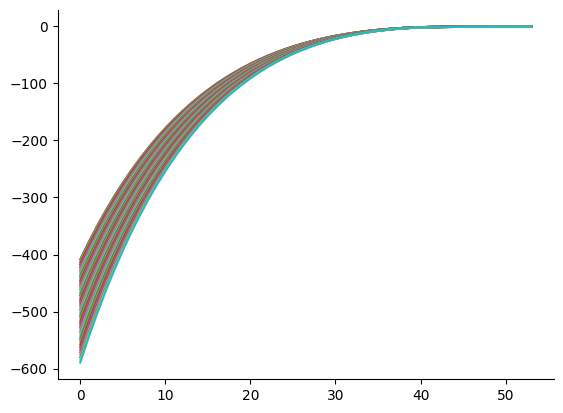

In [17]:
distort_inten =  np.sum(πd_o * g_m * (v_m - v0), axis=0)
# np.save(f"inten_multi_{λ}", distort_inten)
plt.plot(distort_inten)
plt.show()

In [10]:
np.save(f"ems_{λ}", ems)
np.save(f"v_{λ}", v0)

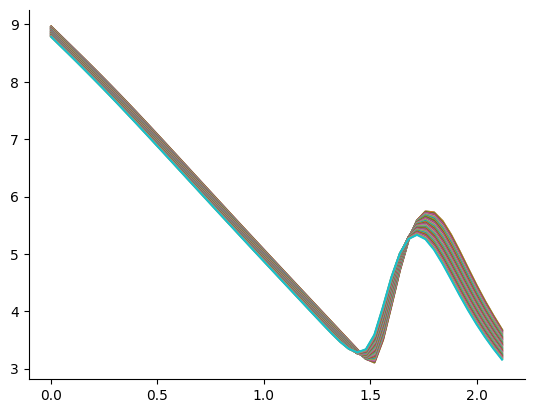

In [11]:
plt.plot(y1_grid_cap, ems)
plt.show()

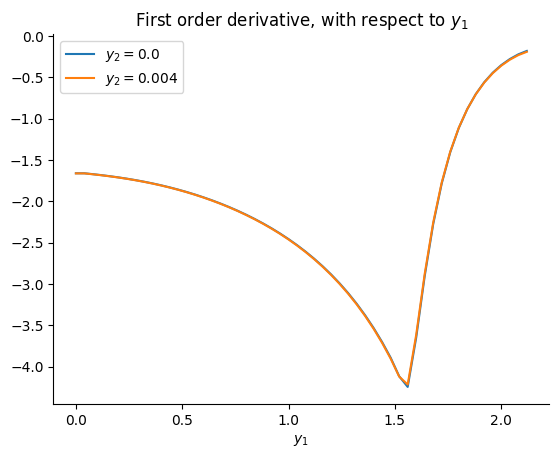

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

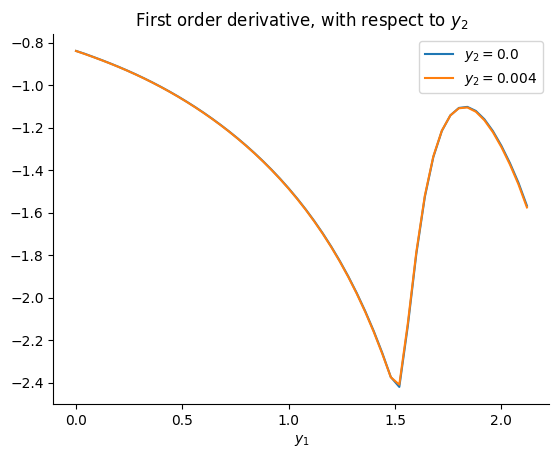

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

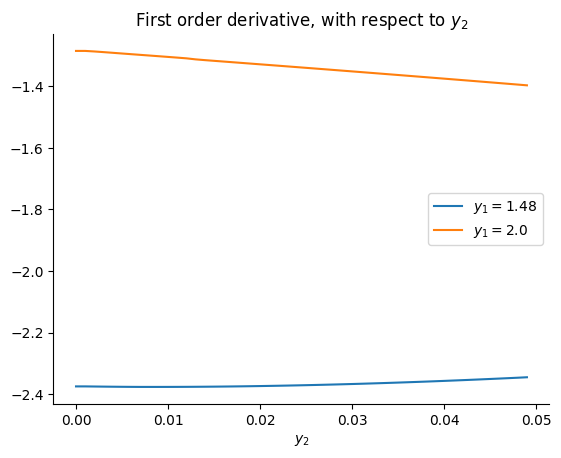

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

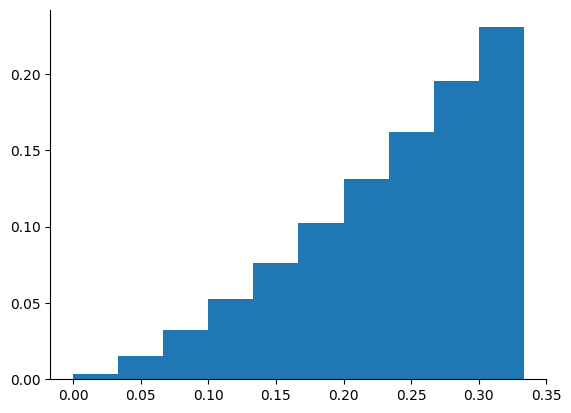

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

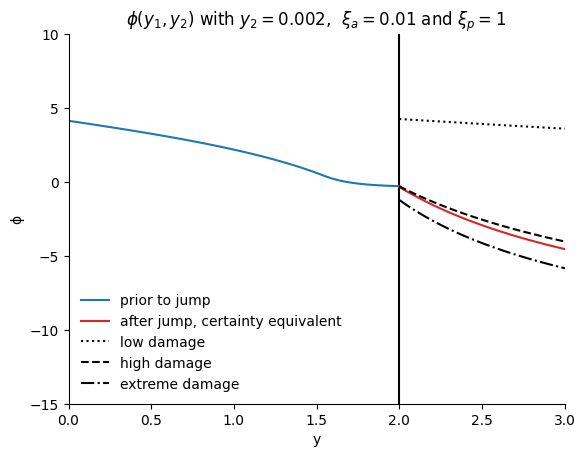

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

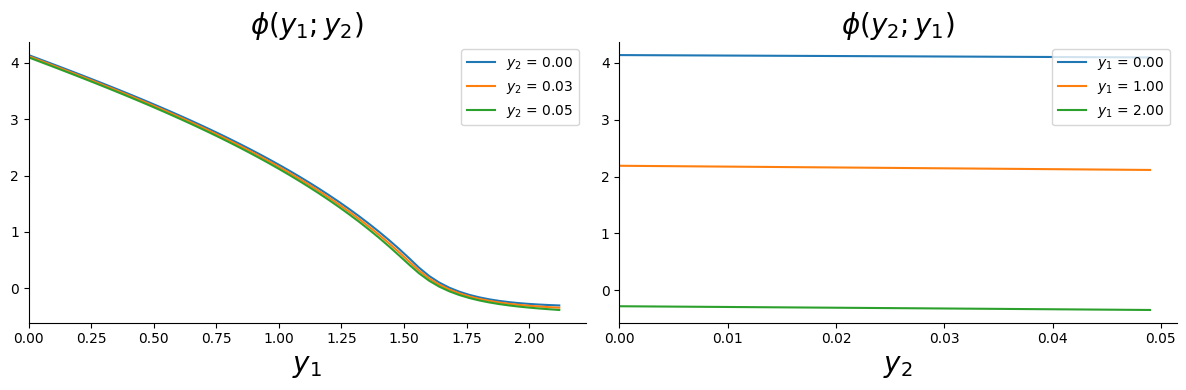

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

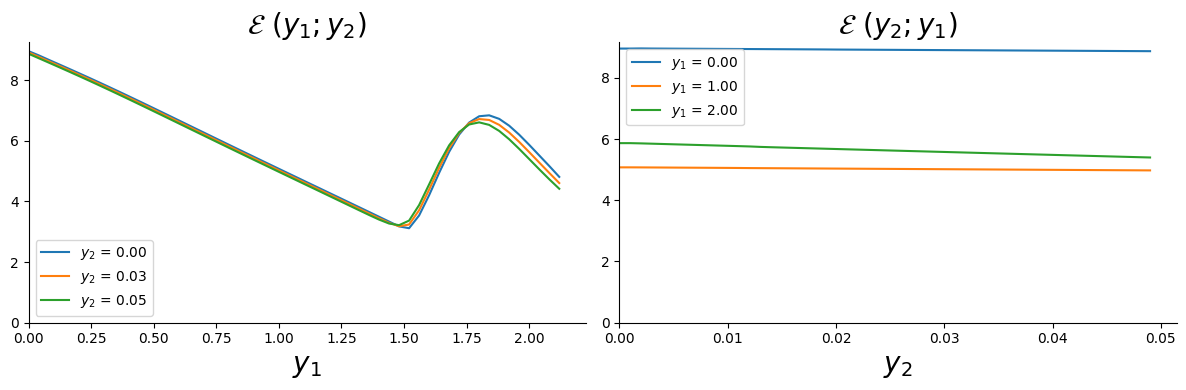

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

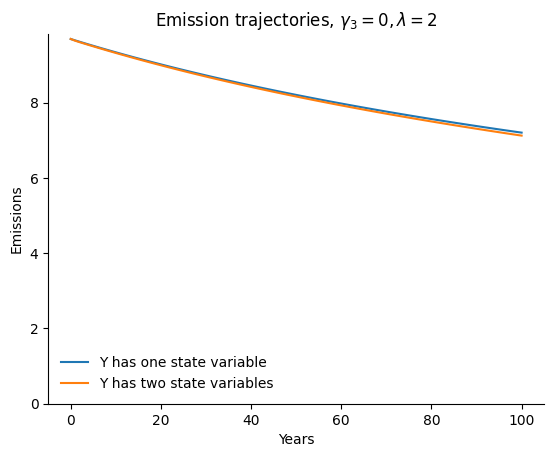

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [44]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [46]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

In [47]:
y1t_prejump

array([1.1       , 1.10778465, 1.11630198, 1.12486182, 1.13337288,
       1.14182344, 1.15021235, 1.15853984, 1.16680635, 1.17501235,
       1.18315829, 1.19124462, 1.19927176, 1.20724014, 1.2151501 ,
       1.22300204, 1.23079639, 1.23853358, 1.24621401, 1.25383811,
       1.26140628, 1.26891893, 1.27637647, 1.28377931, 1.29112785,
       1.29842248, 1.3056636 , 1.31285159, 1.31998684, 1.32706974,
       1.33410054, 1.34107959, 1.3480073 , 1.35488404, 1.36171017,
       1.36848607, 1.37521211, 1.38188863, 1.38851602, 1.39509463,
       1.40162482, 1.40810699, 1.41454161, 1.42092903, 1.4272696 ,
       1.43356365, 1.43981152, 1.44601353, 1.45217175, 1.45828671,
       1.46435873, 1.47038807, 1.47637499, 1.48231974, 1.4882334 ,
       1.4941343 , 1.50002491, 1.50590557, 1.51177631, 1.51763713,
       1.52348801, 1.52939438, 1.53541096, 1.54154764, 1.54780812,
       1.55419519, 1.56071155, 1.56736681, 1.57422201, 1.58129156,
       1.58858345, 1.59610493, 1.60386311, 1.61187521, 1.62016

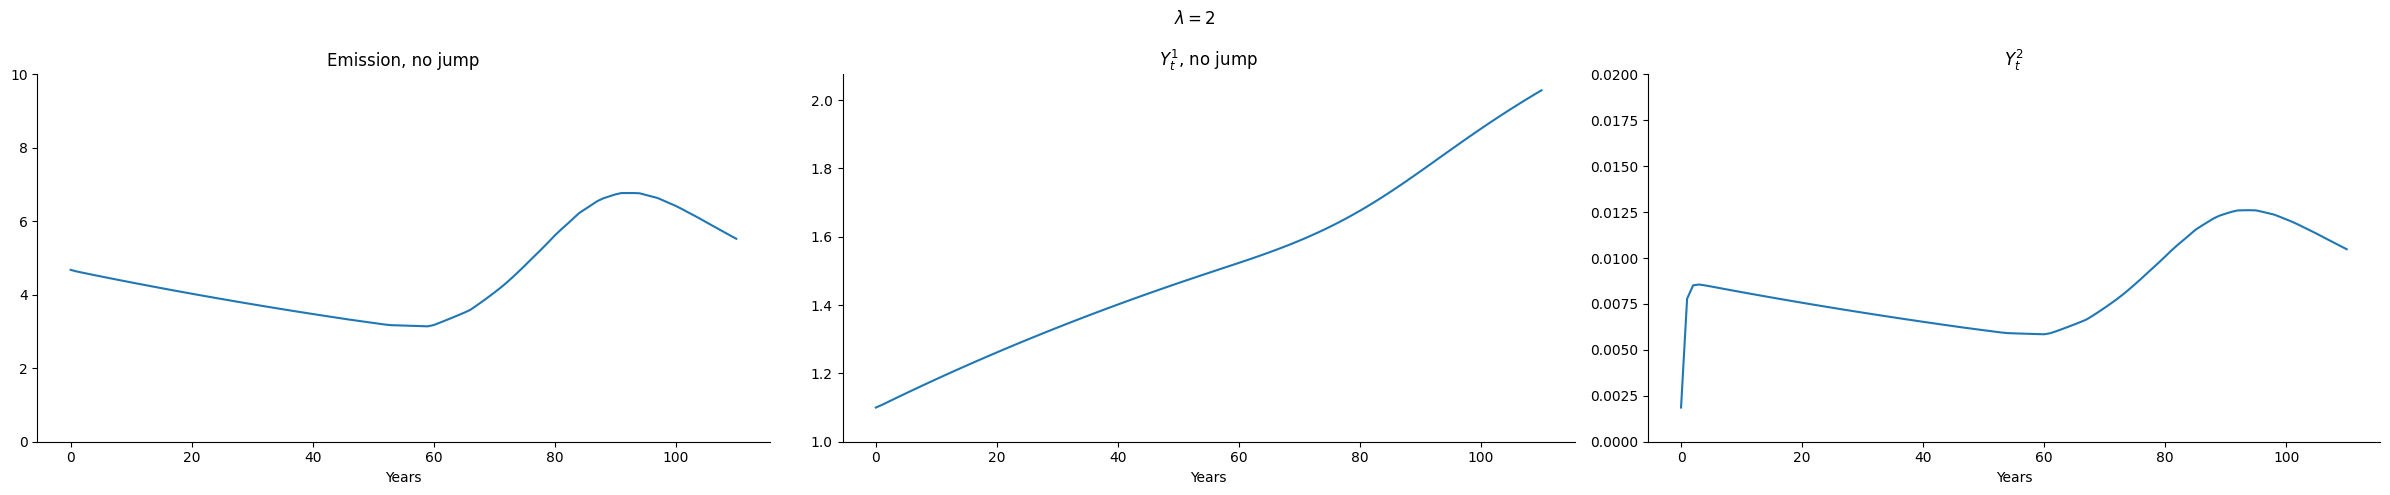

In [48]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [41]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

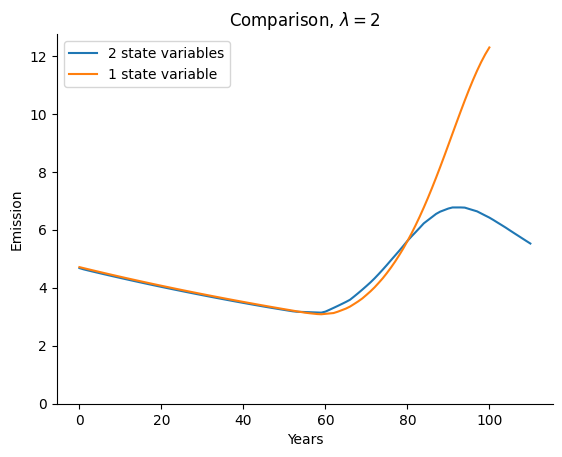

In [49]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

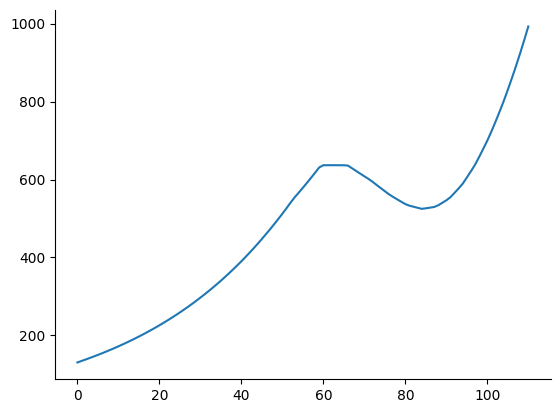

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)